In [11]:
!pip install matplotlib


   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   -------------- ------------------------- 2.9/8.1 MB 16.8 MB/s eta 0:00:01
   ---------------------------- ----------- 5.8/8.1 MB 16.0 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 13.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 11.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------------------- 2.6/2.6 MB 13.7 MB/s eta 0:00:00


In [9]:
!pip install --upgrade numpy scipy


  Using cached numpy-2.2.3-cp312-cp312-win_amd64.whl.metadata (60 kB)
Using cached numpy-2.2.3-cp312-cp312-win_amd64.whl (12.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.61.0 requires numpy<2.2,>=1.24, but you have numpy 2.2.3 which is incompatible.


In [70]:
import pandas as pd
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA



In [16]:
df_temp_out = pd.read_csv('outdoor_temperature.csv')  
df_temp_in = pd.read_csv('indoor_temperature.csv')  
df_heat = pd.read_csv('heating_consumption.csv')  

df_combined = pd.concat([df_temp_out, df_temp_in, df_heat], axis=1)  
date_range = pd.date_range(start='2021-01-01', end='2022-12-28', freq='D')
df_combined['date'] = date_range
print(df_combined)

     5.2000  4.2000  4.4000  3.3000  1.7000  2.8000  1.9000  1.9000.1  2.0000  \
0       0.9     1.4     1.6     0.8    -0.4    -1.1    -1.2      -0.7    -0.7   
1       0.8     0.9     0.9     1.1     1.3     1.3     0.1      -0.6     1.9   
2       0.5     0.2     0.1     0.6     0.3    -0.4    -0.4       0.1     0.8   
3       1.9     1.7     1.3     1.5     1.5     1.3     1.0       0.9     1.1   
4       1.4     1.5     1.5     1.5     1.4     1.5     1.5       1.4     1.7   
..      ...     ...     ...     ...     ...     ...     ...       ...     ...   
722     7.1     7.2     7.6    10.5    11.7     8.5     7.7       8.0    11.0   
723     8.1     7.8     6.9     7.0     5.8     7.8     6.5       7.5     9.1   
724    10.9    11.0    10.7    10.9    10.9    10.6    10.5      10.7    11.0   
725     6.5     6.9     6.3     5.8     4.9     4.8     4.0       5.1     7.3   
726     9.3     8.9     8.7     8.7     9.2     9.1    10.3       9.1     9.8   

     2.3000  ...  0.0000.15

In [17]:
df_no_heating = df_combined[df_combined.iloc[:, -25:-1].sum(axis=1) == 0]  
df_heating = df_combined[df_combined.iloc[:, -25:-1].sum(axis=1) != 0]      

#print(df_no_heating)
df_heating = df_heating.reset_index(drop=True)

print(df_heating)


     5.2000  4.2000  4.4000  3.3000  1.7000  2.8000  1.9000  1.9000.1  2.0000  \
0       0.5     0.2     0.1     0.6     0.3    -0.4    -0.4       0.1     0.8   
1       1.9     1.7     1.3     1.5     1.5     1.3     1.0       0.9     1.1   
2       1.4     1.5     1.5     1.5     1.4     1.5     1.5       1.4     1.7   
3      -3.0    -3.0    -3.4    -3.7    -4.7    -4.6    -4.6      -4.6    -3.0   
4      -3.6    -4.2    -3.8    -4.8    -4.8    -5.0    -5.1      -4.9    -2.4   
..      ...     ...     ...     ...     ...     ...     ...       ...     ...   
240    12.1    12.1    12.3    12.3    12.4    12.2    12.3      12.4    12.8   
241    12.6    12.2    12.0    12.6    12.7    12.6    12.9      13.1    13.3   
242    12.3    11.9    11.9    11.1    10.8    10.5    10.3      10.5    11.0   
243    10.8    10.6    11.1     9.3     9.0     7.9     8.6       9.0    10.6   
244    12.2    10.8    10.6    10.2     9.5     9.3     8.9       8.9    10.8   

     2.3000  ...  0.0000.15

In [18]:
heating_indices = df_heating.index
#print(heating_indices)
df_temp_out_heating = df_temp_out.iloc[heating_indices]
df_temp_in_heating = df_temp_in.iloc[heating_indices]
df_heat_heating = df_heat.iloc[heating_indices]

#print(df_temp_out_heating)
#print(df_temp_in_heating)
#print(df_heat_heating)

In [20]:

def apply_kmeans(data,data_normalized, n_clusters=3):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    data_normalized['cluster'] = kmeans.fit_predict(data_normalized)
    data['cluster']=data_normalized['cluster']
    return kmeans, data


In [26]:
def normalize_data(data):
    scaler = TimeSeriesScalerMeanVariance()  # Normalisation de chaque série temporelle
    data_normalized = scaler.fit_transform(data.values.reshape((data.shape[0], data.shape[1], 1)))
    return pd.DataFrame(data_normalized.reshape(data_normalized.shape[0], data_normalized.shape[1]), columns=data.columns)

df_heating2=df_heating.drop(columns=["date"])
df_normalized = normalize_data(df_heating2)



C:\Users\toubia\anaconda3\envs\notebook\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\toubia\anaconda3\envs\notebook\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [54]:
def apply_cpca(data_normalized, p=3):

    data_normalized = data_normalized.values 
    cov_matrix = np.cov(data_normalized.T)  
    print("Shape de la matrice de covariance:", cov_matrix.shape)
    
    U, Z, e = np.linalg.svd(cov_matrix)
    print(U.shape)
    print(Z.shape)
    print(e.shape)
    S = U[:, :p] 
    projected_data = np.dot(data_normalized, S)  
    return pd.DataFrame(projected_data, columns=[f"PC{i+1}" for i in range(p)])


In [81]:
projected_data = apply_cpca(df_normalized, p=4)

print(projected_data.head)

Shape de la matrice de covariance: (72, 72)
(72, 72)
(72,)
(72, 72)
<bound method NDFrame.head of           PC1       PC2       PC3       PC4
0    2.415520 -0.474486  0.515817  7.522991
1    2.835439 -1.316058  0.591895  7.278485
2    2.761231 -1.204573 -0.149847  7.261994
3    3.776163 -0.142496 -0.035697  7.037745
4    3.599009  0.021876  0.365845  7.109970
..        ...       ...       ...       ...
240 -2.228053 -1.259859  0.539964  7.576725
241 -2.079442 -1.459961  0.661407  7.519949
242 -1.908102 -0.899167  0.152908  7.806518
243 -1.975602 -0.261421  0.781766  7.799730
244 -1.828479 -0.509359 -0.103866  7.819577

[245 rows x 4 columns]>


In [76]:
kmeans, data_normalized_with_cluster = apply_kmeans(df_heating2,projected_data, 4)

df_heating2=df_heating.copy()
df_heating["cluster"]=data_normalized_with_cluster["cluster"]
df_heat_heating.loc[:, "cluster"] = data_normalized_with_cluster["cluster"]
df_temp_in_heating.loc[:, "cluster"] = data_normalized_with_cluster["cluster"]
df_temp_out_heating.loc[:, "cluster"] = data_normalized_with_cluster["cluster"]


In [77]:
def compute_cluster_means(data_normalized, cluster_assignments, column_index):
    cluster_means = {}

    for cluster_id in np.unique(cluster_assignments):
        cluster_data = data_normalized[cluster_assignments == cluster_id].iloc[:, column_index:-1]
        cluster_means[cluster_id] = cluster_data.mean(axis=0)  

    return cluster_means


In [78]:
def plot_clusters_single_variable(data_normalized, cluster_assignments, column_index, y_label="Valeur", num_labels=10):
    cluster_means = compute_cluster_means(data_normalized, cluster_assignments, column_index)

    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    all_values = []
    for cluster_id, cluster_center in cluster_means.items():
        cluster_data = data_normalized[cluster_assignments == cluster_id].iloc[:, column_index:-1]
        all_values.extend(cluster_data.values.flatten())  
    y_min = np.min(all_values)
    y_max = np.max(all_values)

    for cluster_id, cluster_center in cluster_means.items():
        cluster_data = data_normalized[cluster_assignments == cluster_id].iloc[:, column_index:-1]

        for idx, row in cluster_data.iterrows():
            axes[cluster_id // 2, cluster_id % 2].plot(range(24), row, color='gray', alpha=0.5)
        
        axes[cluster_id // 2, cluster_id % 2].plot(range(24), cluster_center, color='red', linewidth=3, label=f"Centre du cluster {cluster_id}")
        
        axes[cluster_id // 2, cluster_id % 2].set_title(f"Séries temporelles du Cluster {cluster_id}")
        axes[cluster_id // 2, cluster_id % 2].set_xlabel("Heures")
        axes[cluster_id // 2, cluster_id % 2].set_ylabel(y_label)
        
        axes[cluster_id // 2, cluster_id % 2].set_ylim([y_min, y_max])
        axes[cluster_id // 2, cluster_id % 2].grid(True)

    plt.tight_layout()
    plt.show()

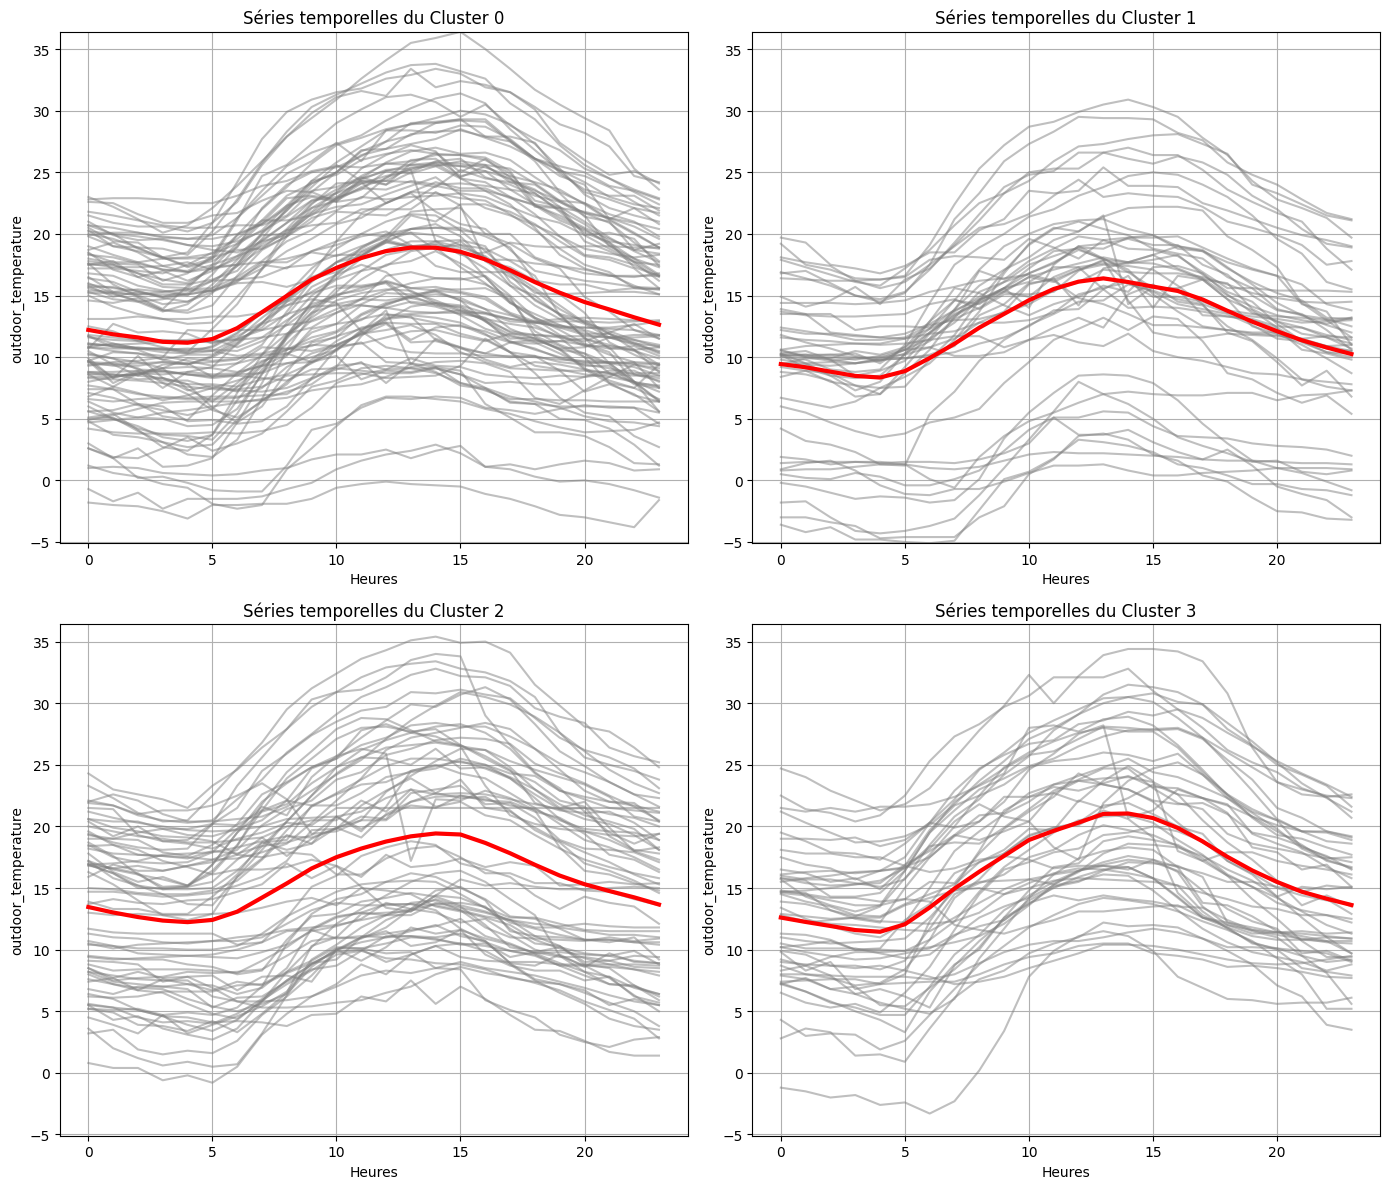

In [79]:
plot_clusters_single_variable(df_temp_out_heating, df_temp_out_heating["cluster"], column_index=0, y_label="outdoor_temperature")


In [80]:

labels = df_heating['cluster'] 
df_heating2=df_heating2.drop(columns=["date"])
sil_score = silhouette_score(df_heating2, labels, metric='euclidean')
db_score = davies_bouldin_score(df_heating2, labels)

print(f"Davies-Bouldin Index: {db_score}")
print(f"Silhouette Score: {sil_score}")


Davies-Bouldin Index: 1.1400466536729257
Silhouette Score: 0.2745732321305846
